<a href="https://colab.research.google.com/github/R21Rash/Lab2/blob/main/ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

X.shape: (2, 400) Y.shape: (1, 400)


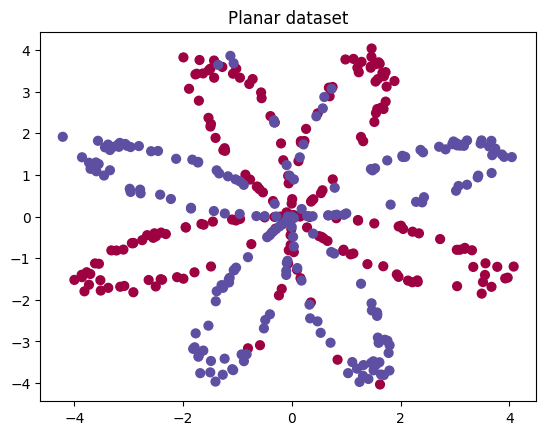

layer_sizes test -> (5, 4, 2)
init W1[0,0]: -0.004167578474054706
forward_propagation test -> means: -0.0004997557777419913 -0.000496963353231779 0.00043818745095914653 0.500109546852431
compute_cost test -> 0.6929198937741271
backprop test dW2[0,0]: 0.0036361325442942527
update_parameters test b2[0,0]: 0.0001045662146
predict test mean: 0.6666666666666666
Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219605
Cost after iteration 9000: 0.218598
Training accuracy: 90.75%


/tmp/ipython-input-179223779.py:195: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_acc = float((np.dot(Y, preds.T) + np.dot(1 - Y, 1 - preds.T)) / Y.size * 100)
/tmp/ipython-input-179223779.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  acc_h = float((np.dot(Y, preds_h.T) + np.dot(1 - Y, 1 - preds_h.T)) / Y.size * 100)


Accuracy for 1 hidden units: 67.50%


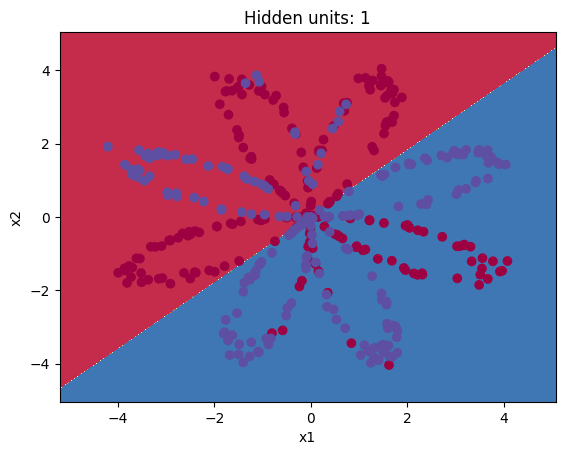

Accuracy for 2 hidden units: 67.25%


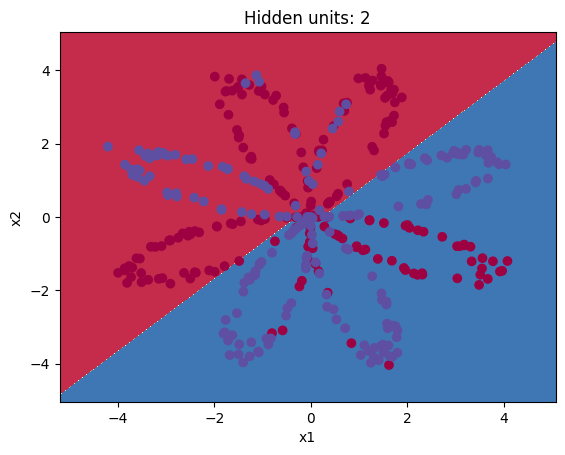

Accuracy for 3 hidden units: 90.75%


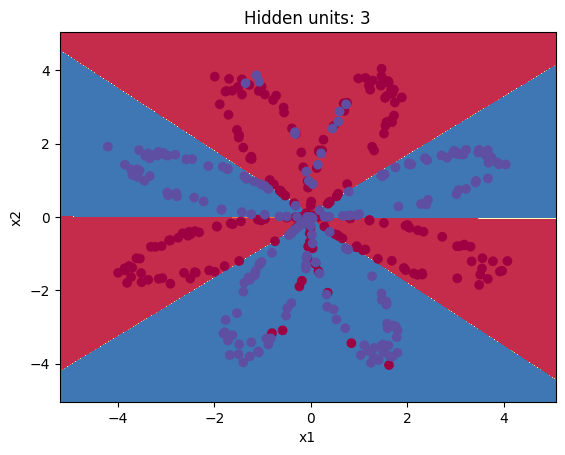

Accuracy for 4 hidden units: 90.50%


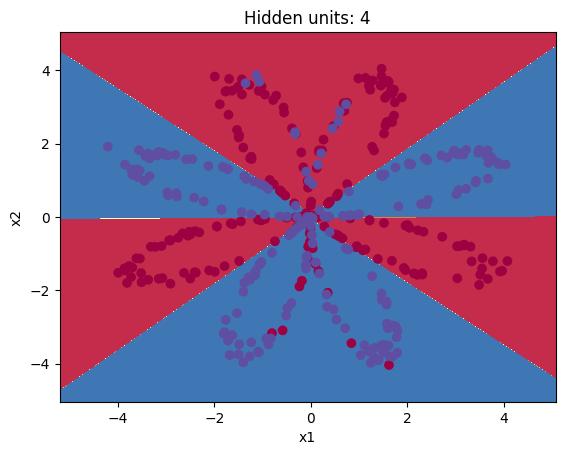

Accuracy for 5 hidden units: 91.25%


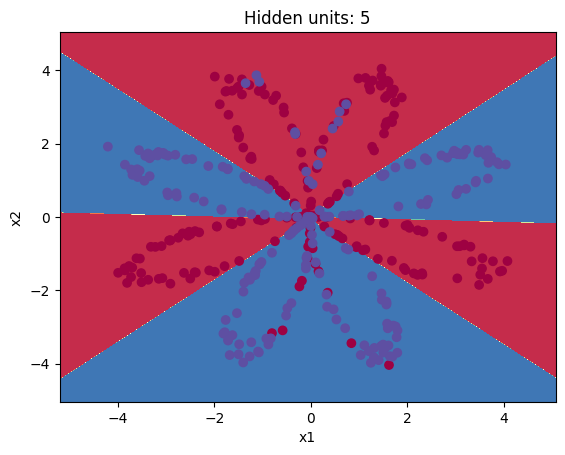

Accuracy for 20 hidden units: 90.00%


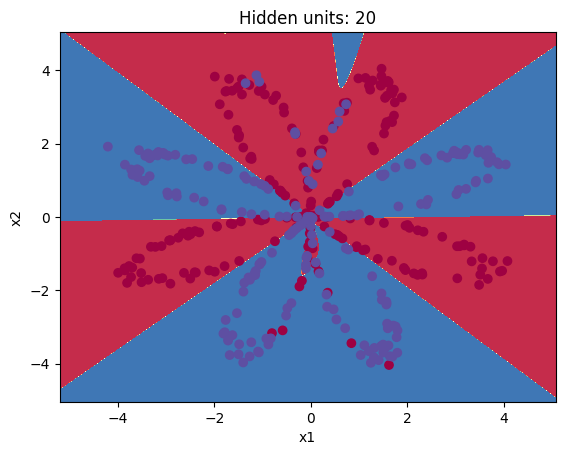

Accuracy for 50 hidden units: 90.25%


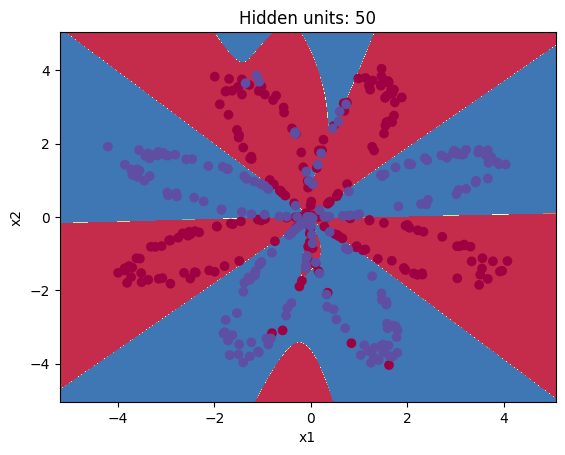

In [1]:
# =========================
# NN_sample - Colab Ready
# =========================

# %% [markdown]
# ## Neural network classification with one hidden layer
# You will:
# - Implement a 2-class neural net with one hidden layer
# - Use tanh nonlinearity
# - Compute cross-entropy loss
# - Implement forward & backward propagation
# - Tune hidden layer size

# %% [code]
# 1) Packages
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline
np.random.seed(1)  # reproducibility

# %% [markdown]
# 2) Dataset

# %% [code]
X, Y = load_planar_dataset()
print("X.shape:", X.shape, "Y.shape:", Y.shape)

# %% [code]
# Visualize
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral)
plt.title("Planar dataset")
plt.show()

# %% [markdown]
# Helper: layer sizes

# %% [code]
def layer_sizes(X, Y):
    n_x = X.shape[0]  # input size
    n_h = 4           # hidden size (will tune later)
    n_y = Y.shape[0]  # output size
    return (n_x, n_h, n_y)

# quick test
X_assess, Y_assess = layer_sizes_test_case()
print("layer_sizes test ->", layer_sizes(X_assess, Y_assess))

# %% [markdown]
# Initialize parameters

# %% [code]
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    # sanity checks
    assert W1.shape == (n_h, n_x)
    assert b1.shape == (n_h, 1)
    assert W2.shape == (n_y, n_h)
    assert b2.shape == (n_y, 1)
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

# test
n_x, n_h, n_y = initialize_parameters_test_case()
p = initialize_parameters(n_x, n_h, n_y)
print("init W1[0,0]:", p["W1"][0,0])

# %% [markdown]
# Forward propagation

# %% [code]
def forward_propagation(X, parameters):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)  # from planar_utils
    assert A2.shape == (1, X.shape[1])
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

# test
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
print("forward_propagation test -> means:",
      np.mean(cache['Z1']), np.mean(cache['A1']),
      np.mean(cache['Z2']), np.mean(cache['A2']))

# %% [markdown]
# Compute cost (cross-entropy)

# %% [code]
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]
    logprobs = np.multiply(np.log(A2 + 1e-12), Y) + np.multiply(np.log(1 - A2 + 1e-12), 1 - Y)
    cost = - np.sum(logprobs) / m
    cost = np.squeeze(cost)
    assert isinstance(cost, float)
    return cost

# test
A2, Y_assess, parameters = compute_cost_test_case()
print("compute_cost test ->", compute_cost(A2, Y_assess, parameters))

# %% [markdown]
# Backward propagation

# %% [code]
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W1, W2 = parameters["W1"], parameters["W2"]
    A1, A2 = cache["A1"], cache["A2"]

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))  # tanh'
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

# test
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()
grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print("backprop test dW2[0,0]:", grads["dW2"][0,0])

# %% [markdown]
# Update parameters (GD)

# %% [code]
def update_parameters(parameters, grads, learning_rate=1.2):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    dW1, db1, dW2, db2 = grads["dW1"], grads["db1"], grads["dW2"], grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

# test
parameters, grads = update_parameters_test_case()
updated = update_parameters(parameters, grads)
print("update_parameters test b2[0,0]:", updated["b2"][0,0])

# %% [markdown]
# Train model (nn_model)

# %% [code]
def nn_model(X, Y, n_h, num_iterations=10000, learning_rate=1.2, print_cost=False):
    np.random.seed(3)
    n_x, _, n_y = layer_sizes(X, Y)
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)

        if print_cost and i % 1000 == 0:
            print(f"Cost after iteration {i}: {cost:.6f}")
    return parameters

# %% [markdown]
# Predict

# %% [code]
def predict(parameters, X):
    A2, _ = forward_propagation(X, parameters)
    return (A2 > 0.5).astype(int)

# test
parameters, X_assess = predict_test_case()
preds = predict(parameters, X_assess)
print("predict test mean:", float(np.mean(preds)))

# %% [markdown]
# Train a model with n_h=4

# %% [code]
parameters = nn_model(X, Y, n_h=4, num_iterations=10000, learning_rate=1.2, print_cost=True)
preds = predict(parameters, X)
train_acc = float((np.dot(Y, preds.T) + np.dot(1 - Y, 1 - preds.T)) / Y.size * 100)
print(f"Training accuracy: {train_acc:.2f}%")

# Optional: decision boundary (uncomment to view)
# plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
# plt.title("Decision boundary (n_h=4)")
# plt.show()

# %% [markdown]
# Hidden layer size tuning (required by the lab text)

# %% [code]
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for n_h in hidden_layer_sizes:
    params_h = nn_model(X, Y, n_h, num_iterations=5000, learning_rate=1.2, print_cost=False)
    preds_h = predict(params_h, X)
    acc_h = float((np.dot(Y, preds_h.T) + np.dot(1 - Y, 1 - preds_h.T)) / Y.size * 100)
    print(f"Accuracy for {n_h} hidden units: {acc_h:.2f}%")

    # Optional visualization (commented to keep it fast)
    plot_decision_boundary(lambda x: predict(params_h, x.T), X, Y)
    plt.title(f"Hidden units: {n_h}")
    plt.show()

# %% [markdown]
#  Write your short answers below (Text cell in Colab):
# Q1: What happens when the number of hidden nodes increases?
#When the number of hidden nodes increases, the neural network has more capacity to learn complex patterns.
#The decision boundary becomes more flexible, and training accuracy usually improves.
# Q2: Explain the pattern of accuracy when the hidden nodes increase.
#- With very few hidden nodes, the model underfits (high bias), giving low accuracy.
#- With a moderate number of nodes, the model captures the pattern well, achieving high accuracy.
#- With a very large number of nodes, the model can overfit the training data (low bias but high variance), which would reduce accuracy on unseen data (if tested on a separate test set).
